Libraries

In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats

Files

In [5]:
# Load the file containing the daily consumption of energy per household
folder = "/Users/mariabelenalberti/OneDrive - Universidad Torcuato Di Tella/Tesis/smart-meters-in-london/daily_dataset.csv/"
filename = "daily_dataset.csv"
daily = pd.read_csv(folder + filename)

In [6]:
# Load the file containing the household information (tariff and acorn)
folder = "/Users/mariabelenalberti/OneDrive - Universidad Torcuato Di Tella/Tesis/smart-meters-in-london/"
filename = "informations_households.csv"
households = pd.read_csv(folder + filename)

In [20]:
# Load the file containing weather variables on a daily basis
folder = "/Users/mariabelenalberti/OneDrive - Universidad Torcuato Di Tella/Tesis/smart-meters-in-london/"
filename = "weather_daily_darksky.csv"
weather = pd.read_csv(folder + filename)
# Filter the file to keep only the max temperature and the corresponding timestamp
weather = weather[['temperatureMax','temperatureMaxTime']]

Data preparation and manipulation

In [21]:
# Weather file when loaded had the timestamp variable as an object, here we transform it to the adecuate type
weather['day']= pd.to_datetime(weather['temperatureMaxTime'],format = '%Y-%m-%d')
del weather['temperatureMaxTime']

In [22]:
# Extract the month and year for ease of analysis
weather['day'] = weather['day'].dt.date
weather['year'] = pd.DatetimeIndex(weather['day']).year
weather['month'] = pd.DatetimeIndex(weather['day']).month
weather['Date'] = pd.to_datetime(weather.year.astype(str) + '-' + weather.month.astype(str))
del weather['year']
del weather['month']
del weather['day']

In [23]:
weather.head()

,temperatureMax,Date
0,11.96,2011-11-01
1,8.59,2011-12-01
2,10.33,2011-12-01
3,8.07,2011-12-01
4,8.22,2011-12-01


In [25]:
# Output of a group by month for the temperature
monthly_weather = weather.groupby(['Date']).mean().reset_index()
monthly_weather

In [27]:
# Here we merge the file 'households' and the file 'daily' using the household id as key
daily_df = pd.merge(daily,households[['LCLid','Acorn_grouped','stdorToU']],on='LCLid')

In [37]:
daily_df.head()

,LCLid,day,energy_mean,Acorn_grouped,stdorToU
0,MAC000131,2011-12-15,0.432045,Affluent,Std
1,MAC000131,2011-12-16,0.296167,Affluent,Std
2,MAC000131,2011-12-17,0.189812,Affluent,Std
3,MAC000131,2011-12-18,0.218979,Affluent,Std
4,MAC000131,2011-12-19,0.325979,Affluent,Std


In [38]:
# We are only interested in specicif varaibles for these analysis, here we filter those
# The purpose is to see if there is statistical evidence of a difference in consumption between the types of tariffs
# and the acorns (separately)
daily_df = pd.DataFrame(daily_df)
daily_df = daily_df[['LCLid','day','energy_mean','Acorn_grouped','stdorToU']]
daily_df.head()

,LCLid,day,energy_mean,Acorn_grouped,stdorToU
0,MAC000131,2011-12-15,0.432045,Affluent,Std
1,MAC000131,2011-12-16,0.296167,Affluent,Std
2,MAC000131,2011-12-17,0.189812,Affluent,Std
3,MAC000131,2011-12-18,0.218979,Affluent,Std
4,MAC000131,2011-12-19,0.325979,Affluent,Std


Difference in means for ACORN consumption

In [39]:
# We are only interested on the consumption and the ACORN, so here we keep only those variables and create four tables
# one for each ACORN
daily_group = daily_df[['energy_mean','Acorn_grouped']]
daily_affluent = daily_group[daily_group['Acorn_grouped']=='Affluent']
daily_adversity = daily_group[daily_group['Acorn_grouped']=='Adversity']
daily_comfortable = daily_group[daily_group['Acorn_grouped']=='Comfortable']
daily_acornu = daily_group[daily_group['Acorn_grouped']=='ACORN-U']

In [40]:
# Since we have the consumption per acorn on differnet tables, it is only necessary to keep the consumption variable
daily_affluent = daily_affluent[['energy_mean']]
daily_adversity = daily_adversity[['energy_mean']]
daily_comfortable = daily_comfortable[['energy_mean']]
daily_acornu = daily_acornu[['energy_mean']]

In [41]:
# t-test for comparing each pair of combinations regrdin the four ACORN groups
test_aff_adv = stats.ttest_ind(daily_affluent.dropna()['energy_mean'],daily_adversity.dropna()['energy_mean'])
test_aff_com = stats.ttest_ind(daily_affluent.dropna()['energy_mean'],daily_comfortable.dropna()['energy_mean'])
test_aff_aco = stats.ttest_ind(daily_affluent.dropna()['energy_mean'],daily_acornu.dropna()['energy_mean'])
test_adv_com = stats.ttest_ind(daily_adversity.dropna()['energy_mean'],daily_comfortable.dropna()['energy_mean'])
test_adv_aco = stats.ttest_ind(daily_adversity.dropna()['energy_mean'],daily_acornu.dropna()['energy_mean'])
test_com_aco = stats.ttest_ind(daily_comfortable.dropna()['energy_mean'],daily_acornu.dropna()['energy_mean'])

In [42]:
display(test_aff_adv.pvalue,
        test_aff_com.pvalue,
        test_aff_aco.pvalue,
        test_adv_com.pvalue,
        test_adv_aco.pvalue,
        test_com_aco.pvalue)

0.0

0.0

0.023781409145063947

0.0

0.0

3.628957846531669e-254

In [43]:
# graphically

In [50]:
# Timestamp column manipulation to ease the group by date
daily_df['timestamp']= pd.to_datetime(daily_df['day'],format = '%Y-%m-%d')
daily_df['year'] = pd.DatetimeIndex(daily_df['timestamp']).year
daily_df['month'] = pd.DatetimeIndex(daily_df['timestamp']).month
daily_df['Date'] = pd.to_datetime(daily_df.year.astype(str) + '-' + daily_df.month.astype(str))
del daily_df['month']
del daily_df['day']
del daily_df['timestamp']

In [56]:
# Saved on a table the result of grouping the consumption by acorn and by date
monthly = daily_df.groupby(['Acorn_grouped','Date']).mean().reset_index()

#Saved on separate tables for each acorn the result of the group by output 
monthly_ACORN = monthly[monthly['Acorn_grouped'] == 'ACORN-']
monthly_ACORN_U = monthly[monthly['Acorn_grouped'] == 'ACORN-U']
monthly_Adversity = monthly[monthly['Acorn_grouped'] == 'Adversity']
monthly_Affluent = monthly[monthly['Acorn_grouped'] == 'Affluent']
monthly_Comfortable = monthly[monthly['Acorn_grouped'] == 'Comfortable']

/Users/mariabelenalberti/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


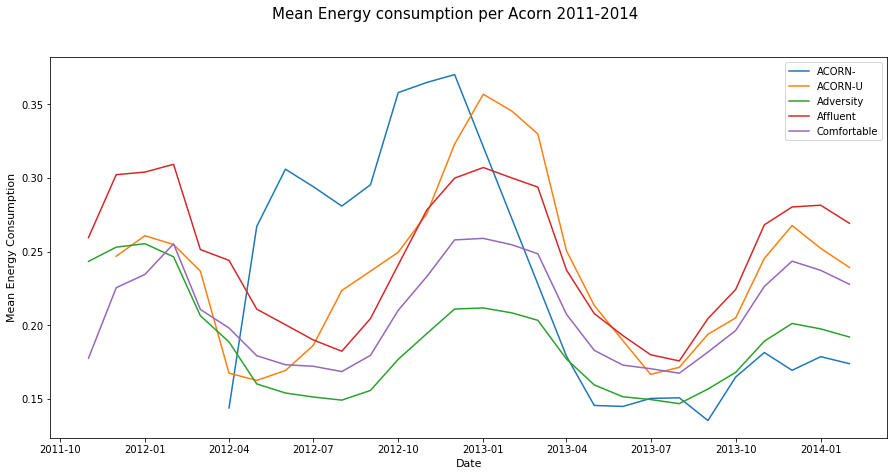

In [59]:
# Ploted the above result
plt.figure(1, figsize=(15, 7)) # Figure size in inches (size_x, size_y)
plt.suptitle('Mean Energy consumption per Acorn 2011-2014', fontsize=15)
plt.plot('Date', 'energy_mean', data = monthly_ACORN)
plt.plot('Date', 'energy_mean', data = monthly_ACORN_U)
plt.plot('Date', 'energy_mean', data = monthly_Adversity)
plt.plot('Date', 'energy_mean', data = monthly_Affluent)
plt.plot('Date', 'energy_mean', data = monthly_Comfortable)
my_labels = ['ACORN-', 'ACORN-U', 'Adversity', 'Affluent', 'Comfortable']
plt.legend(labels = my_labels)
plt.ylabel('Mean Energy Consumption', fontsize = 11) #for y label
plt.xlabel('Date', fontsize = 11) #for x label
plt.savefig('/Users/mariabelenalberti/Downloads/acorn_consumption')

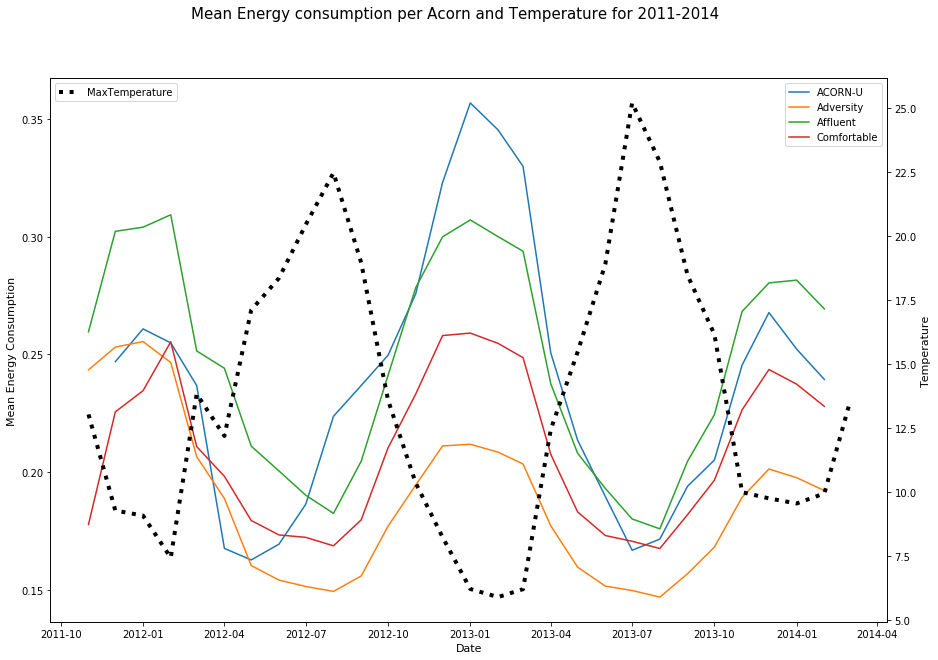

In [61]:
# Same graph as above adding the temperature variable
fig, ax1 = plt.subplots(1,figsize=(15,10))
ax2 = ax1.twinx()
fig.suptitle('Mean Energy consumption per Acorn and Temperature for 2011-2014', fontsize=15)
ax1.plot('Date', 'energy_mean', data = monthly_ACORN_U)
ax1.plot('Date', 'energy_mean', data = monthly_Adversity)
ax1.plot('Date', 'energy_mean', data = monthly_Affluent)
ax1.plot('Date', 'energy_mean', data = monthly_Comfortable)
ax2.plot('Date','temperatureMax',data = monthly_weather,color= "black",linestyle=':' , linewidth=4)

my_labels_1 = ['ACORN-U', 'Adversity', 'Affluent', 'Comfortable', 'MaxTemperature']
my_labels_2 = ['MaxTemperature']
ax1.legend(labels = my_labels_1)
ax2.legend(labels = my_labels_2,loc="upper left")
ax1.set_ylabel('Mean Energy Consumption', fontsize = 11) #for y label
ax1.set_xlabel('Date', fontsize = 11) #for x label
ax2.set_ylabel('Temperature', fontsize = 11) #for y label
plt.savefig('/Users/mariabelenalberti/Downloads/consumption_temp')

Difference in means for type of tariff consumption

In [68]:
# Dynamic pricing was only done during 2013 and so here we filter the data for only the year 2013
year_2013 = daily_df[(daily_df['year'] == 2013) & (daily_df['Acorn_grouped'] != "ACORN-")]

In [69]:
# We saved the output of the mean consumption grouping by type of tariff and acorn
group_mean = year_2013.groupby(['stdorToU','Acorn_grouped']).mean().reset_index()
group_mean = pd.DataFrame(group_mean)

In [70]:
# We saved the output of the standard deviation of consumption grouping by type of tariff and acorn
group_std = year_2013.groupby(['stdorToU','Acorn_grouped']).std().reset_index()
group_std = pd.DataFrame(group_std)
std = group_std[group_std['stdorToU'] == 'Std']
tou = group_std[group_std['stdorToU'] == 'ToU']
std = std[['energy_mean']]
tou = tou[['energy_mean']]

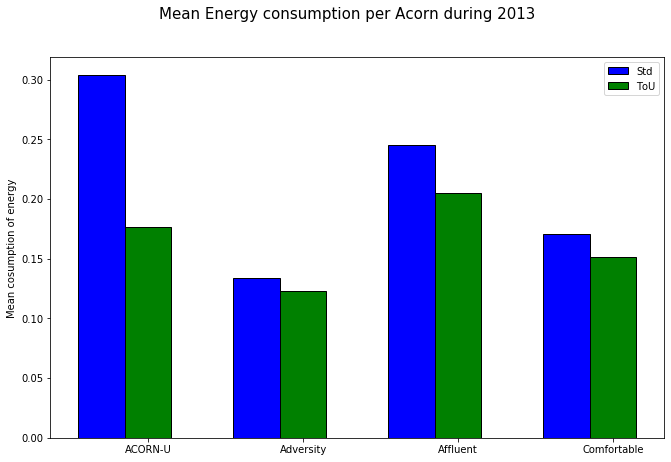

<Figure size 432x288 with 0 Axes>

In [77]:
# Ploted the above results

plt.figure(1, figsize=(11, 7)) # Figure size in inches (size_x, size_y)
plt.suptitle('Mean Energy consumption per Acorn during 2013', fontsize=15)
# width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars
bars1 = std['energy_mean']
 
# Choose the height of the cyan bars
bars2 = tou['energy_mean']

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black',capsize=7, label='Std')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'green', edgecolor = 'black', capsize=7, label='ToU')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['ACORN-U', 'Adversity', 'Affluent','Comfortable'])
plt.ylabel('Mean cosumption of energy')
plt.legend()
 
# Show graphic
plt.show()

# Save graphic
plt.savefig('/Users/mariabelenalberti/Downloads/tariff.png')

In [78]:
#t-test

In [79]:
# First it was necessary to filter the information specific to the year 2013 and the type of tariff
# The above was saved on different tables specific for each acorn
year_2013_std_affluent = year_2013[(year_2013["stdorToU"] == 'Std')&(year_2013["Acorn_grouped"] == 'Affluent')]
year_2013_std_adversity = year_2013[(year_2013["stdorToU"] == 'Std')&(year_2013["Acorn_grouped"] == 'Adversity')]
year_2013_std_comfortable = year_2013[(year_2013["stdorToU"] == 'Std')&(year_2013["Acorn_grouped"] == 'Comfortable')]
year_2013_std_acornu = year_2013[(year_2013["stdorToU"] == 'Std')&(year_2013["Acorn_grouped"] == 'ACORN-U')]
year_2013_tou_affluent = year_2013[(year_2013["stdorToU"] == 'ToU')&(year_2013["Acorn_grouped"] == 'Affluent')]
year_2013_tou_adversity = year_2013[(year_2013["stdorToU"] == 'ToU')&(year_2013["Acorn_grouped"] == 'Adversity')]
year_2013_tou_comfortable = year_2013[(year_2013["stdorToU"] == 'ToU')&(year_2013["Acorn_grouped"] == 'Comfortable')]
year_2013_tou_acornu = year_2013[(year_2013["stdorToU"] == 'ToU')&(year_2013["Acorn_grouped"] == 'ACORN-U')]

In [81]:
# The above result was transformed into a pandas dataframe
year_2013_std_affluent =  pd.DataFrame(year_2013_std_affluent[['energy_mean']])
year_2013_std_adversity = pd.DataFrame(year_2013_std_adversity[['energy_mean']])
year_2013_std_comfortable = pd.DataFrame(year_2013_std_comfortable[['energy_mean']])
year_2013_std_acornu = pd.DataFrame(year_2013_std_acornu[['energy_mean']])
year_2013_tou_affluent = pd.DataFrame(year_2013_tou_affluent[['energy_mean']])
year_2013_tou_adversity = pd.DataFrame(year_2013_tou_adversity[['energy_mean']])
year_2013_tou_comfortable = pd.DataFrame(year_2013_tou_comfortable[['energy_mean']])
year_2013_tou_acornu = pd.DataFrame(year_2013_tou_acornu[['energy_mean']])

In [82]:
# t-test for each pair: for each acorn, the difference in consumption depending on the tariff
test_affluent = stats.ttest_ind(year_2013_std_affluent.dropna()['energy_mean'],year_2013_tou_affluent.dropna()['energy_mean'])
test_adveristy = stats.ttest_ind(year_2013_std_adversity.dropna()['energy_mean'],year_2013_tou_adversity.dropna()['energy_mean'])
test_comfortable = stats.ttest_ind(year_2013_std_comfortable.dropna()['energy_mean'],year_2013_tou_comfortable.dropna()['energy_mean'])
test_acornu = stats.ttest_ind(year_2013_std_acornu.dropna()['energy_mean'],year_2013_tou_acornu.dropna()['energy_mean'])

In [83]:
# p-value for each t-test
display(test_affluent.pvalue,test_adveristy.pvalue,test_comfortable.pvalue,test_acornu.pvalue)

0.0

7.797000884767532e-157

0.0

0.0018257667631896468